In [1]:
#Check system that Jupyter is running on # results --> file path

#import sys
#sys.executable

# Run in terminal -- To check if pandas is installed in the same environment as Jupyter Notebook
#/opt/homebrew/opt/python@3.8/bin/python3.8 -m pip list | grep pandas 

# also numpy and matplotlib, any other packages 

# Run in terminal if packages not installed using:
#/opt/homebrew/opt/python@3.8/bin/python3.8 -m pip install pandas numpy matplotlib statsmodels

# Run in terminal if pylib not installed using:
#/opt/homebrew/opt/python@3.8/bin/python3.8 -m pip install git+https://github.com/wzhengui/pylibs.git

#### If this fails, try again? Failed on first attempt then succeeded when tried again


# import needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylib import *
import calendar

import urllib
import os
import shutil
import zipfile

### Pandas for data manipulation, NumPy for numerical computations, and Matplotlib for data visualization.
### Pylib for all three, plus more useful tools

#navigate to provided website "https://library.ucsd.edu/dc/object/bb4003017c", right click on “Download”, and copy url, you will get this:

url = "https://library.ucsd.edu/dc/object/bb4003017c/_1_1.zip/download"

headers_1 = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'}

output_path = "/Users/kboothomefolder/phy577_projects/hw3/data/bb4003017c.zip"

# request the file from website
req = urllib.request.Request(url, headers=headers_1)

# open it in a file and write it to save it in local
with urllib.request.urlopen(req) as response, open(output_path, 'wb') as f:
    shutil.copyfileobj(response, f)

### Open the zipfile

with zipfile.ZipFile(output_path) as zf:
    print(zf.namelist())
    zf.extractall(path="bb4003017c.zip") # unzips file in current directory as folder
    #zf.extractall(path="/Users/kboothomefolder/phy577_projects/hw1/data/bb4003017c.zip/") # unzips file in current directory as folder

['LaJolla_TEMP_1916-202303.xls', 'LaJolla_SALT_1916-202303.csv', 'LaJolla_SALT_1916-202303.xls', 'LaJolla_TEMP_1916-202303.csv']


In [80]:
########################## Dataset Cleaning & Vars ####################################

########################## Salinity ####################################

# read csv, drop metadata and useless columns, set column header
salt_data = pd.read_csv('/Users/kboothomefolder/phy577_projects/hw3/bb4003017c.zip/LaJolla_SALT_1916-202303.csv') # skiprows=0)
salt_data.iloc[0:50] # check for metadata by index (ind 44 is when data titles start)
salt_data.drop(range(0, 44), axis=0, inplace=True) # drop metadata at top
salt_data.drop(columns=salt_data.columns[-2:], inplace=True) # drop last two blank columns in orig dataframe (TRUE)
# reset first row as column headers
salt_data.columns = salt_data.iloc[0]
salt_data = salt_data[1:]

#replace NaN in TIME_PST column with 0000 and split the 'TIME_PST' into hours and minutes

# mark "bad" flagged times
condition = salt_data['TIME_FLAG'] != 0

#replace "bad" times with 0000 or HHMM
salt_data.loc[condition, 'TIME_PST'] = salt_data.loc[condition, 'TIME_PST'].fillna('0000').astype(str)

# concatenate string, add colon and seconds to end of string
salt_data['time'] = salt_data['TIME_PST'].str[:2] + ':' + salt_data['TIME_PST'].str[2:] + ':00'

#add first three columns for date column in dataset
salt_data['date']=salt_data.iloc[:,0:3].astype(str).apply('-'.join,axis=1)

#print(salt_data['datestr'])     

##################################### Troubleshooting ######################################

''' # Individual errors only, overarching problem with "time" category format more than listed, so function created
# Fix some data error in 'time' category before concatenating to datestr
cond = (salt_data['time'] == '94:0:00') | (salt_data['time'] == '95:5:00')
print(salt_data[cond].index) # 122 indices
ind = salt_data[cond].index
salt_data.loc[ind, 'time'] = '00:00:00'
'''

############################# Clean time column, parse to fit with format %H:%M:%S, and replace if not valid ############
# Assuming 'time' is your column with time values
def clean_time(time_value):
    try:
        # Try to parse the time value
        datetime_obj = pd.to_datetime(time_value, format='%H:%M:%S')
        return time_value  # If it's a valid format, keep the original value
    except ValueError:
        return '00:00:00'  # Replace with '00:00:00' if the format is invalid

# Apply the clean_time_format function to the 'time' column
salt_data['time'] = salt_data['time'].apply(clean_time)

########################### End Troubleshooting ###################################

# combine the date and time column into datestr column
salt_data['datestr'] = salt_data['date'] + ' ' + salt_data['time']
salt_data['datestr']=salt_data['datestr'].astype(str)

# drop not needed columns
salt_data.drop(['TIME_PST', 'TIME_FLAG', 'YEAR', 'MONTH', 'DAY', 'time', 'date'], axis=1, inplace=True)

# Split data into surface and bottom, exclude Nan values and keep only Flag = 0 ("Good" data) for each variable
SSal = salt_data[salt_data['SURF_FLAG'] != 0].dropna(subset=['SURF_SAL_PSU'])
SSal.drop(['BOT_SAL_PSU', 'BOT_FLAG'], axis=1, inplace=True)

# Assign variable types (datestr and numeric)
SSal['datestr'] = pd.to_datetime(SSal.datestr,format='%Y-%m-%d %H:%M:%S')
SSal['SURF_SAL_PSU'] = pd.to_numeric(SSal['SURF_SAL_PSU'])

BSal = salt_data[salt_data['BOT_FLAG'] != 0].dropna(subset=['BOT_SAL_PSU'])
BSal.drop(['SURF_SAL_PSU', 'SURF_FLAG'], axis=1, inplace=True)
BSal['datestr'] = pd.to_datetime(BSal.datestr,format='%Y-%m-%d %H:%M:%S')
BSal['BOT_SAL_PSU'] = pd.to_numeric(BSal['BOT_SAL_PSU'])
SSal.set_index(SSal['datestr'], inplace=True)


# Define variables for timeseries
# Since we skipped the first row when looking at the csv file, we do NOT need to reassign any of the variables because they default to float. 
# NaN is already used for these datasets so no need to replace
# Observations collected daily for the full timeframe

############ Subplots ###################

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.scatter(SSal['datestr'], SSal['SURF_SAL_PSU'], color='red', label='SSal', s=5)
ax1.set_ylabel('Surface Salinity (PSU)')
ax1.legend()
ax2.scatter(BSal['datestr'], BSal['BOT_SAL_PSU'], color='blue', label='BSal', s=5)
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Bottom Salinity (PSU)')
ax2.legend()
plt.suptitle('Surface and Bottom Salinity Time Series')

output_dir = '/Users/kboothomefolder/phy577_projects/hw3/figures'
savefig(os.path.join(output_dir, 'LJ_salinity_noNAN.png'))

##### QQ says look at a shorter period of time to see the salinity gradient

In [80]:
############################## Temperature ##################################

temp_data = pd.read_csv('/Users/kboothomefolder/phy577_projects/hw3/bb4003017c.zip/LaJolla_TEMP_1916-202303.csv') # skiprows=0)
temp_data.iloc[0:50] # check for metadata by index (ind 44 is when data titles start)
temp_data.drop(range(0, 44), axis=0, inplace=True) # drop metadata at top
temp_data.drop(columns=temp_data.columns[-2:], inplace=True) # drop last two blank columns
temp_data.columns = temp_data.iloc[0] 
temp_data = temp_data[1:]

condition = temp_data['TIME_FLAG'] != 0
temp_data.loc[condition, 'TIME_PST'] = temp_data.loc[condition, 'TIME_PST'].fillna('0000').astype(str)
temp_data['time'] = temp_data['TIME_PST'].str[:2] + ':' + temp_data['TIME_PST'].str[2:] + ':00'
temp_data['date']=temp_data.iloc[:,0:3].astype(str).apply('-'.join,axis=1)
temp_data['time'] = temp_data['time'].apply(clean_time)
temp_data['datestr'] = temp_data['date'] + ' ' + temp_data['time']
temp_data['datestr']=temp_data['datestr'].astype(str)

# drop not needed columns
temp_data.drop(columns=temp_data.columns[9:12], inplace=True) 
temp_data.drop(['TIME_PST', 'TIME_FLAG', 'YEAR', 'MONTH', 'DAY', 'time', 'date'], axis=1, inplace=True)
STemp = temp_data[temp_data['SURF_FLAG'] != 0].dropna(subset=['SURF_TEMP_C'])
STemp.drop(['BOT_TEMP_C', 'BOT_FLAG'], axis=1, inplace=True)
BTemp = temp_data[temp_data['BOT_FLAG'] != 0].dropna(subset=['SURF_TEMP_C'])
BTemp.drop(['SURF_TEMP_C', 'SURF_FLAG'], axis=1, inplace=True)

# Assign variable types (datestr and numeric)
STemp['datestr'] = pd.to_datetime(STemp.datestr,format='%Y-%m-%d %H:%M:%S')
STemp['SURF_TEMP_C'] = pd.to_numeric(STemp['SURF_TEMP_C'])
STemp.set_index(STemp['datestr'], inplace=True)

BTemp['datestr'] = pd.to_datetime(BTemp.datestr,format='%Y-%m-%d %H:%M:%S')
BTemp['BOT_TEMP_C'] = pd.to_numeric(BTemp['BOT_TEMP_C'])

BTemp.set_index(BTemp['datestr'], inplace=True)


############################# Temperature Plot #############################3

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.scatter(STemp.datestr, STemp.SURF_TEMP_C, color='red', label='STemp', s=5)
ax1.set_ylabel('Surface Temperature (C)')
ax1.legend()
ax2.scatter(BTemp.datestr, BTemp.BOT_TEMP_C, color='blue', label='BTemp', s=5)
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Bottom Temperature (C)')
ax2.legend()
plt.suptitle('Surface and Bottom Temperature Time Series')

savefig(os.path.join(output_dir, 'LJ_temp_noNAN.png'))

In [119]:
#################### Pick out yearly average trend #####################################

#################### Temperature ###################################

# formerly ST/BT dataframe, make sure to update later code
    
# Resample (see below for descrip) -- Determine the new time intervals to which the data will be aggregated
year_ST_mean = STemp['SURF_TEMP_C'].resample('A').mean() # A = year
year_BT_mean = BTemp['BOT_TEMP_C'].resample('A').mean()
Syears, ST_an = np.asarray(year_ST_mean.index.year), np.asarray(year_ST_mean.values)
Byears, BT_an = np.asarray(year_BT_mean.index.year), np.asarray(year_BT_mean.values)

##################### Salinity #####################################



KeyError: 'datestr'

In [117]:
year_SS_mean = SSal['SURF_SAL_PSU'].resample('A').mean()

BSal.set_index(BSal['datestr'], inplace=True)
year_BS_mean = BSal['SURF_SAL_PSU'].resample('A').mean()

'''
Syears = np.asarray(year_SS_mean.index.year)
SS_an = np.asarray(year_SS_mean.values)

Byears = np.asarray(year_BS_mean.index.year)
BS_an = np.asarray(year_BS_mean.values)
'''

KeyError: 'datestr'

ValueError: 2

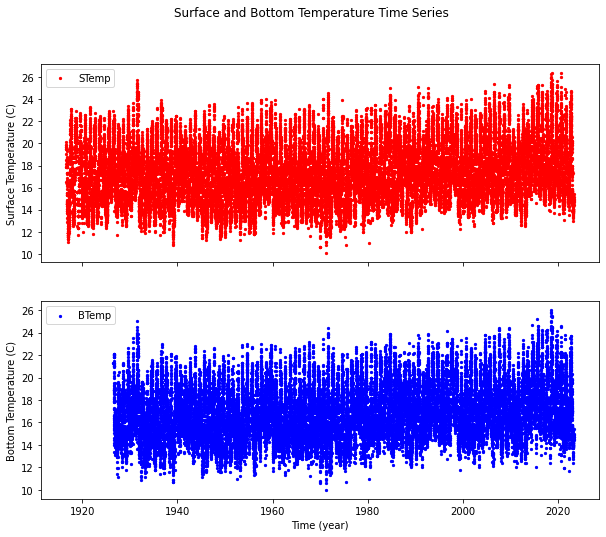

In [100]:
'''

In this code, the set_index method is used to set the 'Time' column as the DataFrame's index, 
which is necessary for resampling. Then, the resample method is used with the frequency 'A' 
to resample the data annually. Finally, the mean function is applied to calculate the yearly 
temperature mean.

In the provided code, the resample method is used to resample time series data
The frequency parameter specifies the frequency at which you want to resample the data. 

Pandas Resample Method:
---> Perform resampling operations on time series data. Particularly useful with time-indexed data and 
you want to change the frequency of the data or calculate aggregated statistics over different time intervals.

Frequency Parameter:
---> Specifies how the data should be resampled. 
Determines the new time intervals to which the data will be aggregated
Takes various string codes to represent different time frequencies. 

Frequency codes include:

'A': Annual frequency (resample to yearly intervals).
'M': Monthly frequency (resample to monthly intervals).
'D': Daily frequency (resample to daily intervals).
'H': Hourly frequency (resample to hourly intervals).
'T' or 'min': Minute frequency (resample to minute intervals).
'S': Second frequency (resample to second intervals).

The above code takes the 'Temperature' column of the DataFrame, resamples it to yearly intervals using 
the 'A' frequency, and then calculates the mean of the values within each yearly interval. 

This results in a new DataFrame that contains the yearly average temperature values.

'''



################## Annual Averages Figures ####################################

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8), sharex=True)

ax1.plot(Syears, ST_an, color='red', marker='o', label='Surface Temp', linestyle='-')
ax1.plot(Byears, BT_an, color='blue', marker='o', label='Bottom Temp', linestyle='-')
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Temperature (C)')
ax1.legend()

ax2.plot(Syears, SS_an, color='red', marker='o', label='Surface Sal', linestyle='-')
ax2.plot(Byears, BS_an, color='blue', marker='o', label='Bottom Sal', linestyle='-')
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Salinity (PSU)')
ax2.legend()
plt.suptitle('Annual Mean Temperature and Salinity Data')

savefig(os.path.join(output_dir, 'LJ_TandS_annAVG.png'))

In [ ]:
########################### Data Distribution ##############################

# Calculate the sample mean and standard deviation

######################## Salinity ##############################3
SS_mean = np.mean(SSal)
BS_mean = np.mean(BSal)
SS_SD = np.std(SSal)
BS_SD = np.std(BSal)

######################## Temperature ##############################3
ST_mean = np.mean(STemp) 
BT_mean = np.mean(BTemp)
ST_SD = np.std(STemp)
BT_SD = np.std(BTemp)

# Determine Bin Size for total dataset

NS = len(SS)
NT = len(STemp)
SSbins = round(3.5 * (SS_SD / (NS ** (-1/3))))
STbins = round(3.5 * (ST_SD / (NT ** (-1/3))))

################################# Monthly Mean and SD #####################################3

# Time is already set to index for ST and SS

################################# Surface Temperature #####################################3

#create empty storage dictionary
ST_monthly_stats = {
    'means': {},
    'std': {},
    'N': {},
    'bins': {},
    'STE_add': {},
    'STE_sub': {}
}

for month in range(1, 13): 
    
    # Filter the DataFrame for the current month
    monthly_ST = ST[ST.index.month == month]
    
    # Calculate and store the stats for the current month in dictionaries
    ST_monthly_stats['means'][month] = monthly_ST['Temperature'].mean()
    ST_monthly_stats['std'][month] = monthly_ST['Temperature'].std()
    ST_monthly_stats['N'][month] = len(monthly_ST)
    ST_monthly_stats['bins'][month] = round(3.5 * ((ST_monthly_stats['std'][month]) / (count ** (-1/3))))
    ST_monthly_stats['STE_add'][month] = ST_monthly_stats['means'][month] + ((ST_monthly_stats['std'][month]) / sqrt(ST_monthly_stats['N'][month]))
    ST_monthly_stats['STE_sub'][month] = ST_monthly_stats['means'][month] - ((ST_monthly_stats['std'][month]) / sqrt(ST_monthly_stats['N'][month]))
                 
################################# Surface Salinity #####################################3

SS_monthly_stats = {
    'means': {},
    'std': {},
    'N': {},
    'bins': {},
    'STE_add': {},
    'STE_sub': {}
}

for month in range(1, 13): 
    
    monthly_SS = SS[SS.index.month == month]
    
    #SS_monthly_stats['means'][month] = mo_mean_S
    SS_monthly_stats['means'][month] = monthly_SS['Salinity'].mean()
    SS_monthly_stats['std'][month] = monthly_SS['Salinity'].std()
    SS_monthly_stats['N'][month] = len(monthly_SS)
    SS_monthly_stats['bins'][month] = round(3.5 * (SS_monthly_stats['std'][month] / (count ** (-1/3))))
    SS_monthly_stats['STE_add'][month] = SS_monthly_stats['means'][month] + (SS_monthly_stats['std'][month] / sqrt(SS_monthly_stats['N'][month]))
    SS_monthly_stats['STE_sub'][month] = SS_monthly_stats['means'][month] - (SS_monthly_stats['std'][month] / sqrt(SS_monthly_stats['N'][month]))

    

'''
####################################  Print Results ####################################################3

for month, mean_temperature in monthly_means_ST.items():
    print(f"Month {month}: Mean Temperature = {round(mean_temperature, 2)} C")
for month, std_temperature in monthly_std_ST.items():
    print(f"Month {month}: Standard Deviation Temperature = {round(std_temperature, 2)} C")
for month, count in N_ST_month.items():
    print(f"Month {month}: N = {count}")
for month, bins in ST_bins.items():
    print(f"Month {month}: Surf Temp Bins = {bins}")
for month, STE_add in STE_plus.items():
    print(f"Month {month}: Surf Temp SE (+) = {round(STE_add, 2)}")
for month, STE_sub in STE_minus.items():
    print(f"Month {month}: Surf Temp SE (-) = {round(STE_sub, 2)}")


for month, mean_salinity in monthly_means_SS.items():
    print(f"Month {month}: Mean Salinity = {round(mean_salinity, 2)} PSU")
for month, std_salinity in monthly_std_SS.items():
    print(f"Month {month}: Standard Deviation Salinity = {round(std_salinity, 2)} PSU")
for month, count in N_SS_month.items():
    print(f"Month {month}: N = {count}")
for month, bins in SS_bins.items():
    print(f"Month {month}: Surf Sal Bins = {bins}")
    
'''
# estimate a bin-averaged probability distribution of the perturbation temperature


In [ ]:
#################################### Plot Monthly Data ######################################

# Convert dictionary keys (months) into a list. 
months = list(SS_monthly_stats['means'].keys())
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Convert values (mean salinity values) from the monthly dictionary into a list. 

SS_means = list(SS_monthly_stats['means'].values())
SS_STE_add = list(SS_monthly_stats['STE_add'].values())
SS_STE_sub = list(SS_monthly_stats['STE_sub'].values())

ST_means = list(ST_monthly_stats['means'].values())
ST_STE_add = list(ST_monthly_stats['STE_add'].values())
ST_STE_sub = list(ST_monthly_stats['STE_sub'].values())


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(months, SS_means, color='red', marker = 'o', label='Mean Surface Salinity')
ax1.plot(months, SS_STE_add, color='green', linestyle = '--', label='Mean + SE')
ax1.plot(months, SS_STE_sub, color='purple', linestyle = '--', label='Mean - SE')
ax1.set_ylabel('Surface Salinity (PSU)')
ax1.legend()
ax1.grid(True) 

ax2.plot(months, ST_means, color='blue', marker = 'o', label='Mean Surface Temperature')
ax2.plot(months, ST_STE_add, color='green', linestyle = '--', label='Mean + SE')
ax2.plot(months, ST_STE_sub, color='purple', linestyle = '--', label='Mean - SE')
ax2.set_ylabel('Surface Temperature (C)')
ax2.set_xlabel('Time (month)')
ax2.legend()
ax2.grid(True)

plt.suptitle('Surface Salinity and Temperature Monthly Means')
plt.xticks(months, month_names, rotation=45)

savefig(os.path.join(output_dir, 'LJ_TandS_Means.png'))


In [ ]:


########################### Surf Salinity Histogram ##############################

# Set the histogram parameters

bin_max = max(SSal)
bin_min = min(SSal)
dbin = 0.1
hist_bins = np.arange(bin_min, bin_max, dbin)

# Compute the normalized histogram
SS_hist, bins = np.histogram(SSal, bins=hist_bins, density=True)

# The 'bins' array contains the bin edges; you can remove the last value to have the same size as the histogram
bins = bins[:-1]

# Plot the histogram
plt.figure(1)
plt.hist(SSal, bins=hist_bins, density=True, alpha=0.5, label='Surface Salinity (PSU)')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
savefig(os.path.join(output_dir, 'LJ_SSal_Hist.png'))

############################## Surf Temp Histogram ##########################################

bin_max = max(STemp)
bin_min = min(STemp)
dbin = 0.2 # bin width - small for salinity
hist_bins = np.arange(bin_min, bin_max, dbin)
ST_hist, bins = np.histogram(STemp, bins=hist_bins, density=True)
bins = bins[:-1]

plt.figure(2)
plt.hist(STemp, bins=hist_bins, density=True, alpha=0.5, label='Surface Temperature (C)')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
savefig(os.path.join(output_dir, 'LJ_STemp_Hist.png'))

# Use the sample mean and standard deviation to estimate a normal distribution (at the bin locations)

# p = (1/(SS_SD*sqrt(2*pi()))) * exp(((x-SS_mean)**2)/(2*(SS_SD**2)))


In [ ]:
hist, bin_edges = np.histogram(data, bins=num_bins, density=True)

# Define the bin centers as the midpoints of the bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generate the estimated normal distribution based on the sample mean and standard deviation
estimated_normal = norm.pdf(bin_centers, loc=sample_mean, scale=sample_stddev)

# Plot the histogram
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), align='center', alpha=0.5, label='Histogram')

# Plot the estimated normal distribution
plt.plot(bin_centers, estimated_normal, 'r', label='Estimated Normal Distribution')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram and Estimated Normal Distribution')
plt.legend()
plt.show()


In [ ]:
###################################### Cut code from orig HW1 ####################################################

In [ ]:
# Check variable types

#print(type(salt_data.SURF_SAL_PSU.iloc[5])) #type float - also temp
#print(type(salt_data.DAY.iloc[5])) # type string
#print(type(salt_data.TIME_PST.iloc[5])) # type float
#print(type(salt_data.SURF_FLAG.iloc[5]) ) # type string

In [ ]:
'''

# Manually compute the means (μs, & μb) 
# mean = sum of all values/total number of values (excluding Nan and Flag = 3)

SSal_mean = np.sum(SSal)/len(SSal) # 33.58119299184165
BSal_mean = np.sum(BSal)/len(BSal) # 33.55872533866715

#print(str("Diff Mean surface = "),SSal_mean - STest_mean)
#print(str("Diff Mean bottom = "),BSal_mean - BTest_mean)

# standard deviations (σs & σb) using basic commands: 
# std_dev = (1/#obs -1) * ((indiv obs 1 - mean)^2 ...(indiv obs 2 - mean)^2)...)


############# Surface Salinity STD DV ##################################3

# Make a variable to store the sum of squared differences (SSD) to be used in calc

SSqD = 0 # 1264.7469925638834

# Iterate through each value in SSal
for obs in SSal:
    SqD = (obs - SSal_mean) ** 2
    SSqD += SqD # Running total - starts at 0 and is updated by adding (+=) the value of SqD to SSqD 
                # in each iteration of the loop, and accumulates the squared differences from each value in the SSal array.

# Calculate the variance (average of squared differences)
varSS = SSqD / (len(SSal)-1) # SD --> 0.18393269900660153 

# Calculate the standard deviation (square root of variance)
S_std_dev = np.sqrt(varSS)

#print(str("STD Diff surface salinity = "),S_std_dev - test_S)

# Had error using ^2, but according to ChatGPT:
############# NOTES: Using ^ in this context would not give you the correct result because ^ is a 
########## bitwise XOR operator in Python, not an exponentiation operator. 
####### Therefore, (value - SSal_mean) ^ 2 would perform a bitwise XOR operation, 
######### which is not the desired mathematical operation for calculating the square of the difference.

############# Bottom Salinity STD DV ##############################################
BSqD = 0 # 1264.7469925638834
for obs in BSal:
    SqD = (obs - SSal_mean) ** 2
    BSqD += SqD 
    
varBS = BSqD / (len(BSal)-1)
B_std_dev = np.sqrt(varBS) # 0.17109802444589484

#print(str("STD Diff bottom salinity = "), B_std_dev - test_B)

# What normalization factor did you use? - Removed all observations where SURF_FLAG != 0 (good values) and all NaNs. 

'''

In [ ]:
'''
# Manually compute the means (μs, & μb) 

STemp_mean = np.sum(STemp)/len(STemp) # 33.58119299184165
STest_mean = np.mean(STemp) # 33.58119299184165

BTemp_mean = np.sum(BTemp)/len(BTemp) # 33.55872533866715
BTest_mean = np.mean(BTemp)

print(str("Diff Mean STemp = "),STemp_mean - STest_mean)
print(str("Diff Mean BTemp = "),BTemp_mean - BTest_mean)

############# Surface Temp STD DV ##################################3


SSqD = 0 # 

for obs in STemp:
    SqD = (obs - STemp_mean) ** 2
    SSqD += SqD 
varST = SSqD / (len(STemp)-1) # SD --> 
S_std_dev = np.sqrt(varST)
test_S = np.std(STemp)
print(str("STD Diff surface temp = "),S_std_dev - test_S)

############# Bottom Salinity STD DV ##############################################
BSqD = 0 # 
for obs in BTemp:
    SqD = (obs - BTemp_mean) ** 2
    BSqD += SqD  
varBT = BSqD / (len(BTemp)-1)
B_std_dev = np.sqrt(varBT) # 
test_B = np.std(BTemp)
print(str("STD Diff bottom temp = "), B_std_dev - test_B)

#print(STemp_mean)
#print(BTemp_mean)
#print(S_std_dev)
#print(B_std_dev)

'''

In [ ]:
'''

# Calculate file fraction of orig data versus ipynb file size. 

ascii = 1410837 + 1465077 
file = 194039 

frac = (ascii - file)/ascii

print(str("file fraction = "), frac, str("bytes"))

'''

In [ ]:
# End check variable types
## converted to numpy array, and using pandas to_numeric to 64 bits

#print(type(SSal[5])) #type float64 - also temp
#print(type(time[5])) # type numpy datetime64


In [ ]:
'''

# Data obs v NaN calculations
### This needs to be done before editing the obs to exclude bad data and NaN's above

#How many obervations? Same for each category due to timeframe
obs = len(SSal) # 38,938 obs
      
#Determine how many observations are not Nan # 1553 32997 38938 33160 resp
nan = np.asarray([len(SSal[np.isnan(SSal)]), len(BSal[np.isnan(BSal)]), len(STemp[np.isnan(STemp)]), len(BTemp[np.isnan(BTemp)])])

valid_obs = (obs - nan)/obs * 100

print(valid_obs) 

# [37385 32997 38938 33160] resp SSal, BSal, STemp, BTemp
# [ 96.0116082   84.74241101 96.69474549  85.16102522] resp SSal, BSal, STemp, BTemp

''


In [ ]:

# Other data observations

SSal_range = max(SSal) - min(SSal)
BSal_range = max(BSal) - min(BSal)

#SSal_var = np.var(SSal)
#BSal_var = np.var(BSal)

print(str("SSal range:"), SSal_range)
print(str("BSal range:"), round(BSal_range, 2))
#print(str("SSal var:"), SSal_var)
#print(str("BSal var:"), BSal_var)

STemp_range = max(STemp) - min(STemp)
BTemp_range = max(BTemp) - min(BTemp)

#STemp_var = np.var(STemp)
#BTemp_var = np.var(BTemp)

print(str("STemp range:"), round(STemp_range, 2))
print(str("BTemp range:"), round(BTemp_range, 2))
#print(str("STemp var:"), STemp_var)
#print(str("BTemp var:"), BTemp_var)

'''
# Difference in manually versus numpy variance
print(str("Variance surface Sal = "), varSS - SSal_var)
print(str("Variance bottom Sal = "), varBS - BSal_var)
print(str("Variance surface Temp = "), varST - STemp_var)
print(str("Variance bottom Temp = "), varBT - BTemp_var)

'''